In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch

In [3]:
import sys
sys.path.append('../functions')
from matplotlib import pyplot as plt
import ad_functions as adfns
import pytesseract
import cv2
import numpy as np
import pandas as pd
import os
import shutil

# psm 6 = Assume a single uniform block of text.
config_tesseract = '--tessdata-dir ./ttesseract_langs --psm 7 digits'

In [4]:
file_path = "./sipaimages/7/"
file_list = os.listdir(file_path)

In [5]:
file_list

['01.jpg',
 '02.jpg',
 '03.jpg',
 '04.jpg',
 '05.jpg',
 '06.jpg',
 '07.jpg',
 '08.jpg',
 '09.jpg',
 '10.jpg']

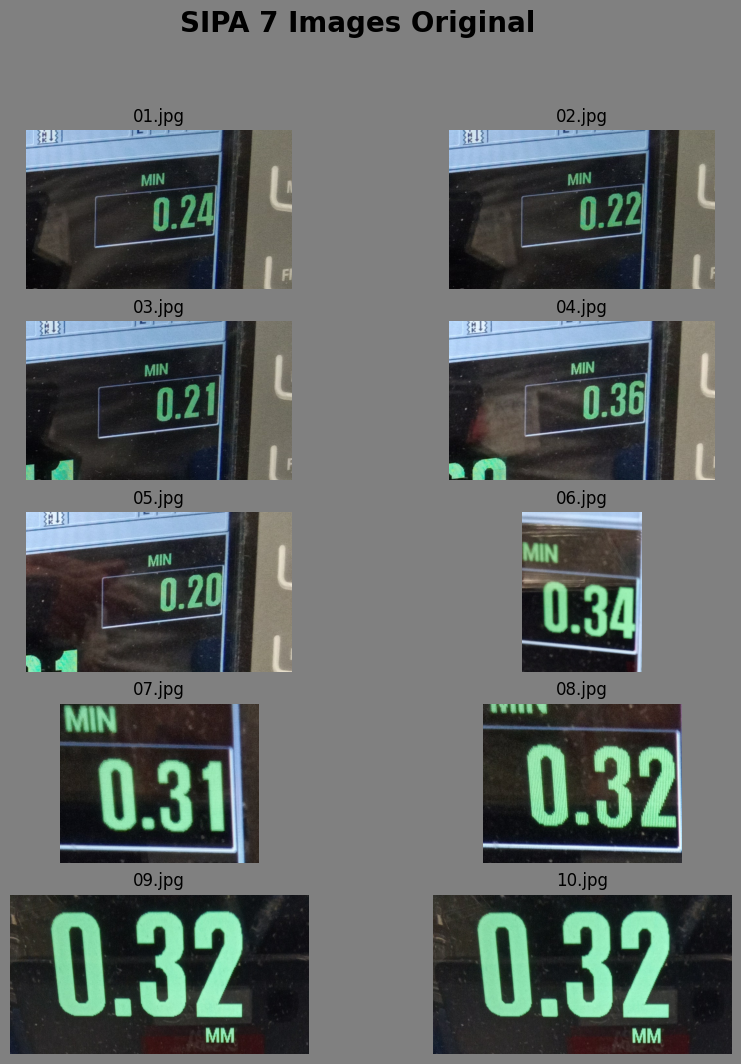

In [6]:

adfns.display_ten_images(file_path, "SIPA 7 Images Original")

01.jpg


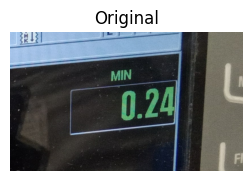

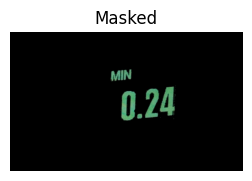

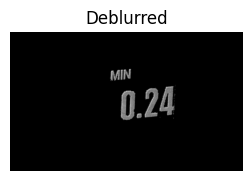

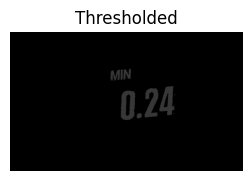

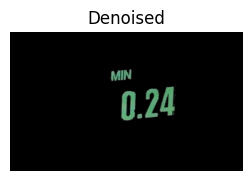

* >>> Original ssd:  4477714
* >>> Masked ssd:  0.24
* >>> Deblurred ssd:  0.20
* >>> Thresh ssd:  0.24
* >>> Deionised ssd:  0.24
****************************************************
* >>> Original eng:  
* >>> Masked eng:  0.24
* >>> Deblurred eng:  0.2
* >>> Thresh eng:  0.2
* >>> Deionised eng:  0.2
****************************************************
02.jpg


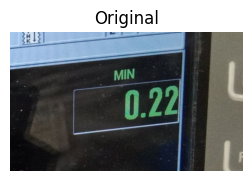

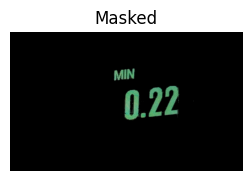

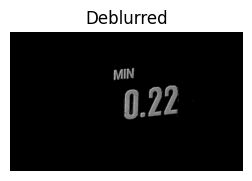

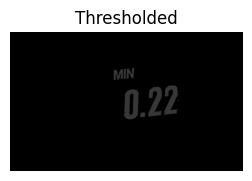

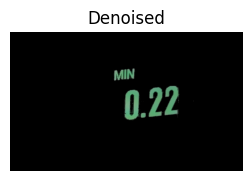

* >>> Original ssd:  
* >>> Masked ssd:  0.02
* >>> Deblurred ssd:  0.12
* >>> Thresh ssd:  1
* >>> Deionised ssd:  11
****************************************************
* >>> Original eng:  
* >>> Masked eng:  0.2
* >>> Deblurred eng:  0.2
* >>> Thresh eng:  0.22
* >>> Deionised eng:  022
****************************************************
03.jpg


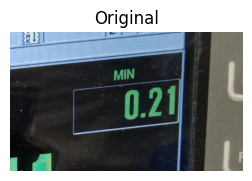

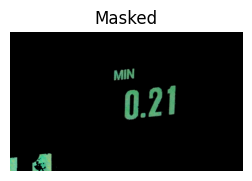

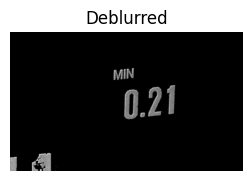

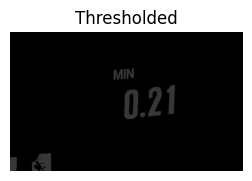

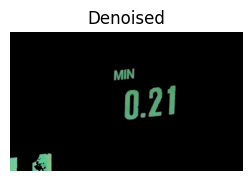

* >>> Original ssd:  
* >>> Masked ssd:  110.21
* >>> Deblurred ssd:  110
* >>> Thresh ssd:  1410
* >>> Deionised ssd:  10.1
****************************************************
* >>> Original eng:  
* >>> Masked eng:  0.21
* >>> Deblurred eng:  .
* >>> Thresh eng:  
* >>> Deionised eng:  021
****************************************************
04.jpg


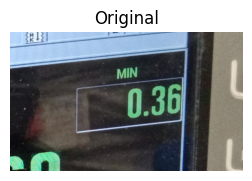

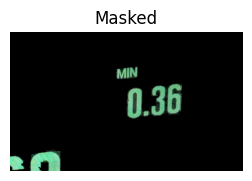

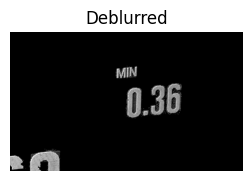

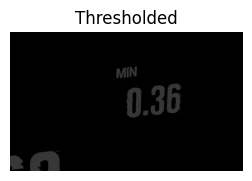

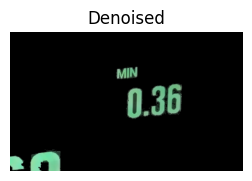

* >>> Original ssd:  4520
* >>> Masked ssd:  170.96
* >>> Deblurred ssd:  10.96
* >>> Thresh ssd:  10.36
* >>> Deionised ssd:  10.96
****************************************************
* >>> Original eng:  .
* >>> Masked eng:  30.36
* >>> Deblurred eng:  0.36
* >>> Thresh eng:  0.36
* >>> Deionised eng:  30.36
****************************************************
05.jpg


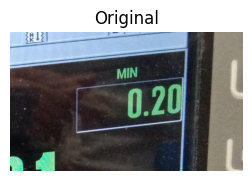

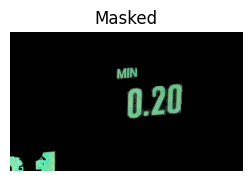

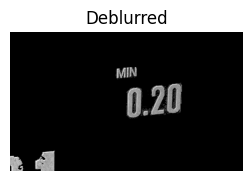

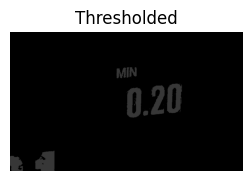

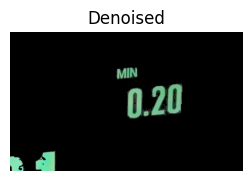

* >>> Original ssd:  
* >>> Masked ssd:  10.10
* >>> Deblurred ssd:  110.00
* >>> Thresh ssd:  1111
* >>> Deionised ssd:  10.10
****************************************************
* >>> Original eng:  
* >>> Masked eng:  0.20
* >>> Deblurred eng:  0.20
* >>> Thresh eng:  0.20
* >>> Deionised eng:  0.20
****************************************************
06.jpg


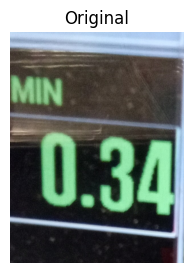

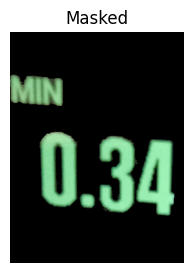

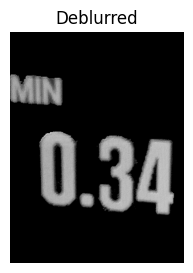

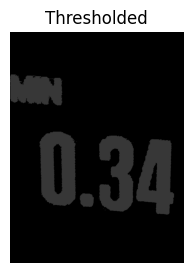

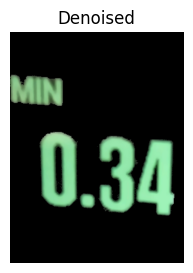

* >>> Original ssd:  
* >>> Masked ssd:  67
* >>> Deblurred ssd:  0.34
* >>> Thresh ssd:  0.34
* >>> Deionised ssd:  67
****************************************************
* >>> Original eng:  
* >>> Masked eng:  031
* >>> Deblurred eng:  038
* >>> Thresh eng:  0.3
* >>> Deionised eng:  038
****************************************************
07.jpg


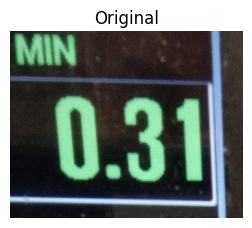

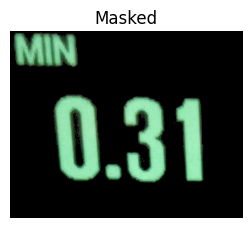

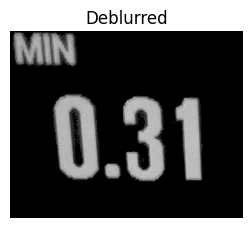

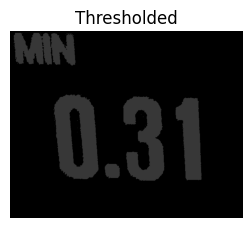

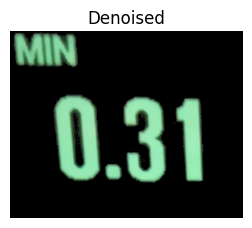

* >>> Original ssd:  0311
* >>> Masked ssd:  061
* >>> Deblurred ssd:  0.31
* >>> Thresh ssd:  0.31
* >>> Deionised ssd:  061
****************************************************
* >>> Original eng:  031
* >>> Masked eng:  031
* >>> Deblurred eng:  031
* >>> Thresh eng:  031
* >>> Deionised eng:  031
****************************************************
08.jpg


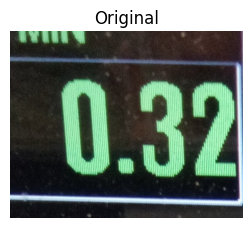

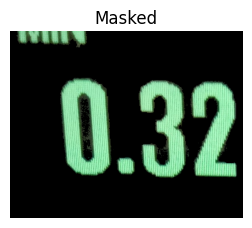

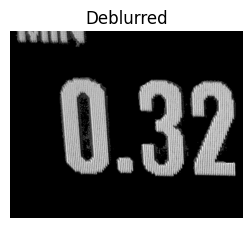

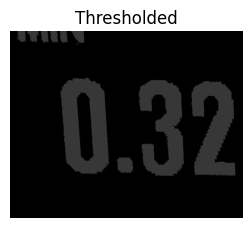

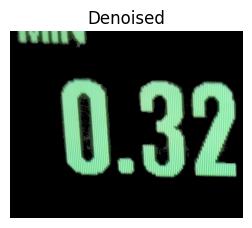

* >>> Original ssd:  
* >>> Masked ssd:  0.32
* >>> Deblurred ssd:  0.32
* >>> Thresh ssd:  0.32
* >>> Deionised ssd:  0
****************************************************
* >>> Original eng:  
* >>> Masked eng:  032
* >>> Deblurred eng:  032
* >>> Thresh eng:  0.32
* >>> Deionised eng:  032
****************************************************
09.jpg


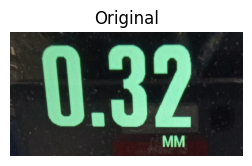

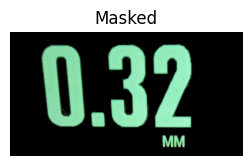

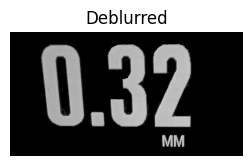

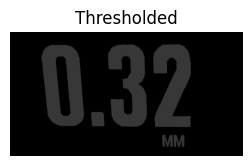

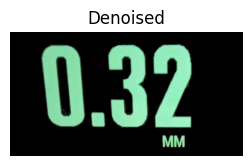

* >>> Original ssd:  0.30
* >>> Masked ssd:  0.32
* >>> Deblurred ssd:  0.32
* >>> Thresh ssd:  0.32
* >>> Deionised ssd:  0.32
****************************************************
* >>> Original eng:  032
* >>> Masked eng:  0.32
* >>> Deblurred eng:  0.32
* >>> Thresh eng:  0.32
* >>> Deionised eng:  0.32
****************************************************
10.jpg


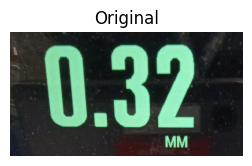

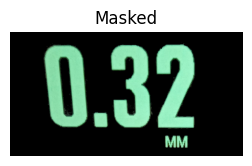

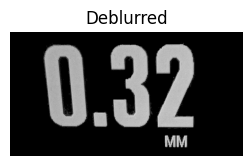

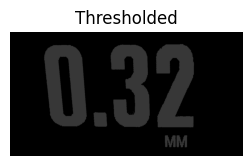

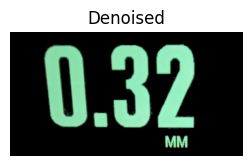

* >>> Original ssd:  0.32
* >>> Masked ssd:  0.32
* >>> Deblurred ssd:  0.32
* >>> Thresh ssd:  0.32
* >>> Deionised ssd:  0.32
****************************************************
* >>> Original eng:  032
* >>> Masked eng:  0.32
* >>> Deblurred eng:  0.32
* >>> Thresh eng:  0.32
* >>> Deionised eng:  0.32
****************************************************


In [7]:
# image deblurring

for filename in file_list:
    print(filename)

    img = cv2.imread(file_path + filename)
    # img_resized = adfns.read_resize_data(img, 400)

    img_masked_green = adfns.mask_green(img)
    # Load the image
    # img = cv2.imread("./manually_cropped/4/mancrop_02.jpg")

    # Convert the image to grayscale
    gray = cv2.cvtColor(img_masked_green, cv2.COLOR_BGR2GRAY)

    # Define the blur kernel (e.g., Gaussian blur kernel)
    kernel_size = 5
    kernel = cv2.getGaussianKernel(kernel_size, 0)
    psf = kernel @ kernel.T

    # Define the Wiener filter
    snr = 0.1  # signal-to-noise ratio
    psf /= np.sum(psf)
    otf = np.fft.fft2(psf)
    otf = np.conj(otf) / (np.abs(otf)**2 + snr)
    wiener_filter = np.fft.ifft2(otf)

    # Perform deconvolution using the Wiener filter
    deblurred = cv2.filter2D(gray, -1, wiener_filter.real)

    # Apply thresholding to the deblurred image
    thresh = cv2.threshold(deblurred, 0, 55, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    dst = cv2.fastNlMeansDenoisingColored(img_masked_green, None, 6, 16, 7, 21)
    denoise_image = adfns.denoise_image(img_masked_green)

    # Display the original and normalized images
    adfns.show_img(img, 3, title="Original")
    adfns.show_img(img_masked_green, 3, title="Masked")
    adfns.show_img(deblurred, 3, title="Deblurred")
    adfns.show_img(thresh, 3, title="Thresholded")
    adfns.show_img(dst, 3, title="Denoised")

    text_ssd_original, text_eng_original  = adfns.get_text(img)
    text_ssd_masked, text_eng_masked    = adfns.get_text(img_masked_green)
    text_ssd_deblurred, text_eng_deblurred  = adfns.get_text(deblurred)
    text_ssd_thresh, text_eng_thresh    = adfns.get_text(thresh)
    text_ssd_deionised, text_eng_deionised = adfns.get_text(denoise_image)

    print("* >>> Original ssd: ", text_ssd_original)
    print("* >>> Masked ssd: ", text_ssd_masked)
    print("* >>> Deblurred ssd: ", text_ssd_deblurred)
    print("* >>> Thresh ssd: ", text_ssd_thresh)
    print("* >>> Deionised ssd: ", text_ssd_deionised)
    print("****************************************************")

    print("* >>> Original eng: ", text_eng_original)
    print("* >>> Masked eng: ", text_eng_masked)
    print("* >>> Deblurred eng: ", text_eng_deblurred)
    print("* >>> Thresh eng: ", text_eng_thresh)
    print("* >>> Deionised eng: ", text_eng_deionised)
    print("****************************************************")



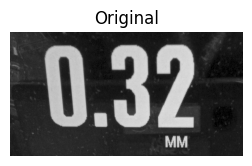

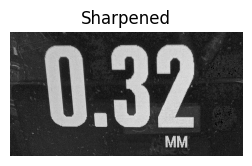

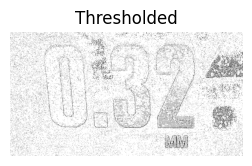

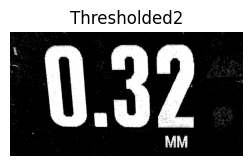

* >>> 


In [15]:
# Create a matrix of ones, then multiply it by a scaler of 100 
# This gives a matrix with same dimesions of our image with all values being 100
M = np.ones(image.shape, dtype = "uint8") * 100 

# Load the image
img = cv2.imread("./sipaimages/7/10.jpg",0)

# Create our shapening kernel, remember it must sum to one 
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])

# applying the sharpening kernel to the image
sharpened = cv2.filter2D(img, 0, kernel_sharpening)

# Using adaptiveThreshold
thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 5) 
_, th2 = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

adfns.show_img(img, 3, title="Original")
adfns.show_img(sharpened, 3, title="Sharpened")
adfns.show_img(thresh, 3, title="Thresholded")
adfns.show_img(th2, 3, title="Thresholded2")


text_ssd, _ = adfns.get_text(sharpened)

print("* >>>", text_ssd)


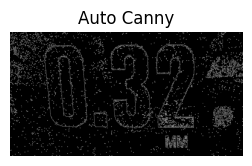

In [16]:
def autoCanny(image):
  # Finds optimal thresholds based on median image pixel intensity
  blurred_img = cv2.blur(image, ksize=(5,5))
  med_val = np.median(image) 
  lower = int(max(0, 0.66 * med_val))
  upper = int(min(255, 1.33 * med_val))
  edges = cv2.Canny(image=image, threshold1=lower, threshold2=upper)
  return edges

auto_canny = autoCanny(th2)
adfns.show_img(auto_canny, 3, title="Auto Canny")


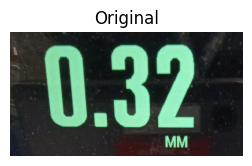

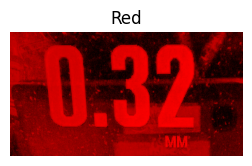

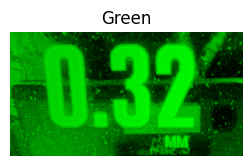

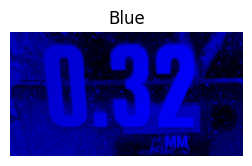

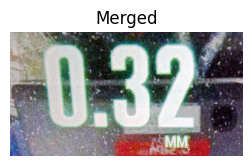

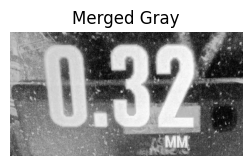

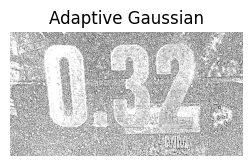

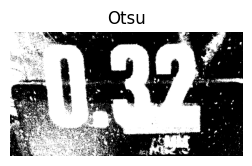

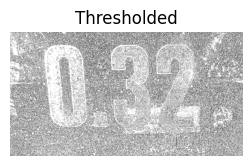

* >>> img 0.32
* >>> red_img 81016744218600605751641400406595086006.67904185471931880.81400360180089186608.080651064010014044405011141623088108680171594430034000000640888000000.0.1491041894.7883000770.66110444080004506105.0782006103031061810002101846006144.01161821006.6158314423910510.776418145065487088011786911412000800751002414.908088840.4800.000778004006080800000003800867750000011980415071118817880660070004.011.11111.110740
* >>> green_img 0000008006016.780078114070016610000.54130005008601024314948483400066681507174960088591.5276984164171044406060671718760641117.054114911117480114614413141498806000608431251847416180804144444144058668765718.04860.048144118425306118112680008686990984.000005000000078141889800006980000060000861716.071600040161416202000058.8618800085400041188608888000065006916510840860030.0662151.460
* >>> blue_img 06888106684891611870.7085.6700008068636000000041910460146994181914018447140749117771140.1887011816781666183110.0080164111006526356446468118311691648614008.808

In [17]:

img = cv2.imread("./sipaimages/7/10.jpg")

adfns.show_img(img, 3, title="Original")

# Equalize our Histogram
# Default color format is BGR 

red_channel = img[:, :, 2]
red = cv2.equalizeHist(red_channel)

green_channel = img[:, :, 1]
green = cv2.equalizeHist(green_channel)

blue_channel = img[:, :, 0]
blue = cv2.equalizeHist(blue_channel)

# create empty image with same shape as that of src image
red_img = np.zeros(img.shape)
red_img[:,:,2] = red
red_img = np.array(red_img, dtype=np.uint8)
adfns.show_img(red_img, 3, title="Red")

green_img = np.zeros(img.shape)
green_img[:,:,1] = green
green_img = np.array(green_img, dtype=np.uint8)
adfns.show_img(green_img, 3, title="Green")

blue_img = np.zeros(img.shape)
blue_img[:,:,0] = blue
blue_img = np.array(blue_img, dtype=np.uint8)
adfns.show_img(blue_img, 3, title="Blue")

merged = cv2.merge([blue, green, red])
adfns.show_img(merged, 3, title="Merged")

merged_gray = cv2.cvtColor(merged, cv2.COLOR_BGR2GRAY)
adfns.show_img(merged_gray, 3, title="Merged Gray")

# merged_otsu = adfns.process_otsu(merged_gray)

# 255 is a value that is going to be assigned to respectively pixels in the result
# (namely, to all pixels which value in the source is greater then computed threshold level)
max_threshold = 255

merged_adaptive_gaussian = cv2.adaptiveThreshold(
    merged_gray, max_threshold, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9
)

adfns.show_img(merged_adaptive_gaussian, 3, title="Adaptive Gaussian")

# 0 means threshold level which actually is omitted because we used CV_THRESH_OTSU flag
min_threshold = 0

# 255 is a value that is going to be assigned to respectively pixels in the result
# (namely, to all pixels which value in the source is greater then computed threshold level)
max_threshold = 255

# THRESH_BINARY | THRESH_OTSU is a required flag to perform Otsu thresholding. Because in fact we would like to perform binary thresholding,
# so we use CV_THRESH_BINARY (you can use any of 5 flags opencv provides) combined with CV_THRESH_OTSU
value, merged_otsu  = cv2.threshold(
    merged_gray, min_threshold, max_threshold, cv2.THRESH_BINARY | cv2.THRESH_OTSU
)

adfns.show_img(merged_otsu, 3, title="Otsu")

thresh = cv2.adaptiveThreshold(merged_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 5) 
adfns.show_img(thresh, 3, title="Thresholded")



text_ssd_img, _                      = adfns.get_text(img)
text_ssd_red_img, _                  = adfns.get_text(red_img)
text_ssd_green_img, _                = adfns.get_text(green_img)
text_ssd_blue_img, _                 = adfns.get_text(blue_img)
text_ssd_merged, _                   = adfns.get_text(merged)
text_ssd_merged_gray, _              = adfns.get_text(merged_gray)
text_ssd_merged_adaptive_gaussian, _ = adfns.get_text(merged_adaptive_gaussian)
text_ssd_merged_otsu, _              = adfns.get_text(merged_otsu)


print("* >>> img", text_ssd_img)
print("* >>> red_img", text_ssd_red_img)
print("* >>> green_img", text_ssd_green_img)
print("* >>> blue_img", text_ssd_blue_img)
print("* >>> merged", text_ssd_merged)
print("* >>> merged_gray", text_ssd_merged_gray)
print("* >>> merged_adaptive_gaussian", text_ssd_merged_adaptive_gaussian)
print("* >>> merged_otsu", text_ssd_merged_otsu)



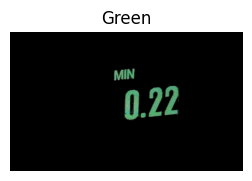

In [8]:
img = cv2.imread("./sipaimages/7/02.jpg")



img_green = adfns.mask_green(img)

adfns.show_img(img_green, 3, title="Green")

In [17]:
dir(adfns)

['__builtins__',
 '__cached__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'control_loop_sipa3',
 'crop_image',
 'cv2',
 'denoise_image',
 'display_four_images',
 'display_ten_images',
 'get_text',
 'is_image',
 'mask_green',
 'mask_red',
 'np',
 'os',
 'pd',
 'plt',
 'process_adaptive_gaussian',
 'process_file_closing',
 'process_file_thresh',
 'process_otsu',
 'pytesseract',
 'random',
 're',
 'read_input_file_list',
 'read_resize_data',
 'show_img']

In [11]:


def detect_rotation(image):
    # Load the image and convert it to grayscale
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a binary threshold to the image
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Find contours in the image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour and its bounding box
    max_contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(max_contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Draw the bounding box on the image
    cv2.drawContours(img, [box], 0, (0, 0, 255), 2)

    # Calculate the angle of rotation needed to straighten the image
    angle = rect[2]

    # Rotate the image
    rows, cols = img.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated = cv2.warpAffine(img, M, (cols, rows))

    adfns.show_img(rotated, 3, title="Rotated")

    # Use Pytesseract to read the digits in the rotated image
    text = adfns.get_text(rotated)

    return text, angle


In [18]:

# def read_digits_and_text_from_image(image_path):
#     # Read image using OpenCV
#     image = cv2.imread(image_path)

#     # Convert image to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Apply thresholding to remove noise
#     _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#     # Dilate the image to make the digits more clear
#     kernel = np.ones((3,3), np.uint8)
#     dilation = cv2.dilate(thresh, kernel, iterations=1)

#     # Find contours in the image
#     contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Extract digits and text from the contours
#     digits = []
#     text = []
#     for contour in contours:
#         # Get bounding rectangle of contour
#         x, y, w, h = cv2.boundingRect(contour)

#         # Crop the contour from the image
#         cropped = gray[y:y+h, x:x+w]
#         adfns.show_img(cropped, 3, title="Cropped")

#         # Determine whether the cropped image is a digit or text by checking the aspect ratio
#         aspect_ratio = float(w)/h
#         if aspect_ratio > 0.6:
#             # The cropped image is a digit
#             # Resize the digit to a fixed size for better recognition
#             digit = cv2.resize(cropped, (28, 28))

#             # Apply thresholding to the digit
#             _, digit = cv2.threshold(digit, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#             # Use Pytesseract to recognize the digit
#             digit_text = pytesseract.image_to_string(digit, config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')

#             # Append the recognized digit to the list
#             digits.append(int(digit_text))
#         else:
#             # The cropped image is text
#             # Use Pytesseract to recognize the text
#             text.append(pytesseract.image_to_string(cropped))

#     return digits, text


In [44]:

# def read_digits_and_text_from_image(image_path):
#     # Read the image using OpenCV
#     img = cv2.imread(image_path)

#     # Convert the image to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     # Threshold the image using Otsu's method
#     _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#     # Dilate the image to make the digits more clear
#     kernel = np.ones((3, 3), np.uint8)
#     dilated = cv2.dilate(thresh, kernel, iterations=1)

#     # Find contours in the image
#     contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Initialize lists to store the recognized digits and text
#     digits = []
#     text = []

#     # Loop over the contours
#     for contour in contours:
#         # Get the bounding rectangle of the contour
#         x, y, w, h = cv2.boundingRect(contour)

#         # Crop the contour from the image
#         cropped = gray[y:y+h, x:x+w]

#         # Check if the contour is likely to be a digit
#         aspect_ratio = w / h
#         area = w * h
#         if aspect_ratio > 0.2 and aspect_ratio < 1.8 and area > 50 and area < 5000:
#             # Resize the cropped image to a fixed size for better recognition
#             digit = cv2.resize(cropped, (28, 28))

#             # Apply thresholding to the digit
#             _, digit = cv2.threshold(digit, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#             # Use Pytesseract to recognize the digit
#             digit_text = pytesseract.image_to_string(digit, config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')

#             # Check if a digit was recognized and append it to the list
#             if digit_text:
#                 digits.append(int(digit_text))
#         else:
#             # Use Pytesseract to recognize the text
#             text.append(pytesseract.image_to_string(cropped))

#     # Return the recognized digits and text
#     return digits, text


In [49]:

# def read_text_from_image(image_path):
#     # Read the image using OpenCV
#     img = cv2.imread(image_path)

#     # Convert the image to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     # Threshold the image using Otsu's method
#     _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#     # Dilate the image to make the text more clear
#     kernel = np.ones((3, 3), np.uint8)
#     dilated = cv2.dilate(thresh, kernel, iterations=1)

#     # Find contours in the image
#     contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Initialize a list to store the recognized text
#     text = []

#     # Loop over the contours
#     for contour in contours:
#         # Get the bounding rectangle of the contour
#         x, y, w, h = cv2.boundingRect(contour)

#         # Crop the contour from the image
#         cropped = gray[y:y+h, x:x+w]

#         # Use Pytesseract to recognize the text
#         text.append(pytesseract.image_to_string(cropped))

#     # Return the recognized text
#     return text


In [61]:

def read_digits_and_text_from_image(image_path):
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    img_masked_green = adfns.mask_green(img)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img_masked_green, cv2.COLOR_BGR2GRAY)

    # Threshold the image using Otsu's method
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Dilate the image to make the digits more clear
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=1)

    # Find contours in the image
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize lists to store the recognized digits and text
    digits = []
    text = []

    # Loop over the contours
    for contour in contours:
        # Get the bounding rectangle of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Crop the contour from the image
        cropped = gray[y:y+h, x:x+w]

        # Check if the contour is likely to be a digit
        aspect_ratio = w / h
        area = w * h
        if aspect_ratio > 0.2 and aspect_ratio < 1.8 and area > 50 and area < 5000:
            # Resize the cropped image to a fixed size for better recognition
            digit = cv2.resize(cropped, (28, 28))

            # Apply thresholding to the digit
            _, digit = cv2.threshold(digit, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

            # Use Pytesseract to recognize the digit
            digit_text = pytesseract.image_to_string(digit, config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')

            # Check if a digit was recognized and append it to the list
            if digit_text:
                digits.append(int(digit_text))
                print(f'Recognized digit: {digit_text}')
            else:
                print('No digit recognized')
            
            # Print the cropped and thresholded images for debugging purposes
            # adfns.show_img(cropped, 3, title="Cropped Digit")
        else:
            # Use Pytesseract to recognize the text
            text.append(pytesseract.image_to_string(cropped))
            
            # Print the cropped image for debugging purposes
            # adfns.show_img(cropped, 3,title="Cropped Text")

    # Return the recognized digits and text
    return digits, text


In [63]:
def read_text_from_image(image_path):
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold the image using Otsu's method
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Dilate the image to make the text more clear
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=1)

    # Find contours in the image
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a list to store the recognized text
    text = []

    # Loop over the contours
    for contour in contours:
        # Get the bounding rectangle of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Crop the contour from the image
        cropped = gray[y:y+h, x:x+w]

        # Use Pytesseract to recognize the text
        text.append(pytesseract.image_to_string(cropped))

    # Return the recognized text
    return text


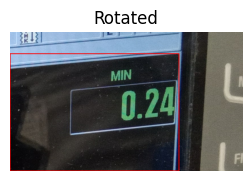

The text in the image is: ('', '')
The angle of rotation needed is: -0.0


In [33]:
text, angle = detect_rotation("./sipaimages/7/01.jpg")
print("The text in the image is:", text)
print("The angle of rotation needed is:", angle)

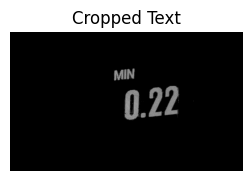

([], ['MIN\n\n0.22\n'])


In [58]:
digits = read_digits_and_text_from_image("./sipaimages/7/02.jpg")
print(digits)

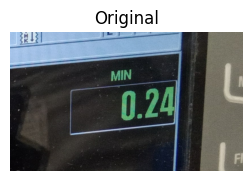

In [43]:
img = cv2.imread("./sipaimages/7/01.jpg")

adfns.show_img(img, 3, title="Original")

In [64]:
for filename in file_list:
    print(filename)
    # img = cv2.imread(file_path + filename)

    digits = read_digits_and_text_from_image(file_path + filename)
    print(digits)

    


01.jpg
([], ['MIN\n\n0.24\n'])
02.jpg
([], ['MIN\n\n0.22\n'])
03.jpg
([], ['', '5\n\nMIN\n\n0.21\n'])
04.jpg
No digit recognized
([], [''])
05.jpg
Recognized digit: 7

([7], ['', ''])
06.jpg
([], [''])
07.jpg
([], ['0.31\n'])
08.jpg
([], ['Ween\n'])
09.jpg
([], ['0.32\n'])
10.jpg
([], ['0.32\n'])


In [65]:
for filename in file_list:
    print(filename)
    # img = cv2.imread(file_path + filename)

    digits = read_text_from_image(file_path + filename)
    print(digits)

01.jpg
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
02.jpg
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
03.jpg
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
04.jpg
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
05.jpg
['', '', '', '', '', '', 'ORR\n', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',